# DQNを構築する

In [58]:
from pathlib import Path
import gym
import math
import random
import math
import copy
import numpy as np
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import settings

In [2]:
%load_ext autoreload
%autoreload 2

## パラメータの設定

In [60]:
gym_game_name = 'Pendulum-v1'

In [59]:
result_dir_path = Path('result')
if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)

## ゲーム環境を構築

In [3]:
action_list = [-1, 1]

In [4]:
env = gym.make(gym_game_name)
dim_state = env.env.observation_space.shape[0]

## DQNのモデルを構築する

In [134]:
class DQN(nn.Module):
    
    def __init__(self, input_dim, output_dim):

        super(DQN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 30)
        self.layer2 = nn.Linear(30, 30)
        self.layer3 = nn.Linear(30, 30)
        self.layer_output = nn.Linear(30, output_dim)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer_output(x)

In [135]:
def select_action(policy_net, state, action_list, epsilon, is_train=True):

    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    
    if not is_train:
        with torch.no_grad():
            return action_list[policy_net(state).max(1)[1].detach().item()]

    if random.random() > epsilon:
        with torch.no_grad():
            return action_list[policy_net(state).max(1)[1].detach().item()]
    else:
        return action_list[random.randrange(len(action_list))]

In [136]:
def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)


def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

In [137]:
main_net = DQN(input_dim=dim_state, output_dim=len(action_list))
target_net = DQN(input_dim=dim_state, output_dim=len(action_list))
target_net.eval()

DQN(
  (layer1): Linear(in_features=3, out_features=30, bias=True)
  (layer2): Linear(in_features=30, out_features=30, bias=True)
  (layer3): Linear(in_features=30, out_features=30, bias=True)
  (layer_output): Linear(in_features=30, out_features=2, bias=True)
)

## DQNの学習

In [138]:
def learn_model(main_net, target_net, batch, action_list, optimizer, is_train=True):

    (states, actions, rewards, next_states, dones) = zip(*batch)

    states = np.array(states)
    states = torch.tensor(states, dtype=torch.float32)
    dones = np.array(dones).astype(int)
    dones = torch.tensor(dones, dtype=torch.float32)
    next_states = np.array(next_states)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    rewards = np.array(rewards)
    rewards = torch.tensor(rewards, dtype=torch.float32)

    action_indexes = torch.tensor([action_list.index(a) for a in actions])

    q_values = main_net(states).gather(1, action_indexes.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        q_values_next_target = target_net(next_states)
        q_values_next = main_net(next_states)
        action_indexes = q_values_next.max(axis=1)[1]
        future_returns = q_values_next_target.gather(1, action_indexes.unsqueeze(1)).squeeze(1)
        # future_returns = q_values_next_target.max(1)[0]
        q_values_next_target = rewards + (1 - dones) * gamma * future_returns

    loss = F.mse_loss(q_values, q_values_next_target)

    if is_train:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()

In [139]:
max_episode =  300
max_step = 200
n_warmup_steps = 10000
gamma = 0.99
epsilon = 0.1
memory_size = 10000
batch_size = 32
tau = 0.01
episode_print_interval = 10

In [140]:
optimizer = optim.Adam(main_net.parameters())

In [141]:
def normalize_reward(reward):
    if reward < -1:
        reward = -1
    else:
        reward = 1
    return reward

In [142]:
memory = []
total_step = 0
step = 0
state = env.reset()
while True:

    step += 1
    total_step += 1

    action = random.choice(action_list)

    next_state, reward, done, info = env.step([action])
    c_reward = normalize_reward(reward=reward)

    memory.append((state, action, c_reward, next_state, done))
    state = next_state

    if step > max_step:
        state = env.reset()
        step = 0
        
    if total_step > n_warmup_steps:
        break

memory = memory[-memory_size:]
print('warming up {:,} steps... done.'.format(n_warmup_steps))

warming up 10,000 steps... done.


In [143]:
goal_episode_reward = 0
episode_reward_list = []
loss_list = []

num_episode = 1
episode_loop = True
while episode_loop:

    state = env.reset()

    episode_reward = 0
    done = False
    while not done:
        
        action = select_action(
            policy_net=main_net, state=state, action_list=action_list, epsilon=epsilon
        )
        next_state, reward, done, info = env.step([action])
        c_reward = normalize_reward(reward=reward)
        
        memory.append((state, action, c_reward, next_state, done))
        episode_reward += reward
        state = next_state
        batch = random.sample(memory, batch_size)
        
        loss = learn_model(
            main_net=main_net, target_net=target_net, batch=batch, action_list=action_list,
            optimizer=optimizer, is_train=True
        )

        loss_list.append(loss)

        soft_update(target_net, main_net, tau=tau)

        memory = memory[-memory_size:]

    episode_reward_list.append(episode_reward)

    if num_episode % episode_print_interval == 0:
        print('[{}/{}] Reward: {:.0f}, Last{} Reward: {:.0f}'.format(
            num_episode, max_episode, episode_reward,
            episode_print_interval, np.mean(episode_reward_list[-episode_print_interval:]), 
        ))

    if len(episode_reward_list) > episode_print_interval:
        if np.mean(episode_reward_list[-episode_print_interval:]) == max_step:
            break

    if num_episode >= max_episode or episode_reward == goal_episode_reward:
        episode_loop = False
    
    num_episode += 1

env.close()

[10/300] Reward: -745, Last10 Reward: -1094
[20/300] Reward: -124, Last10 Reward: -558
[30/300] Reward: -588, Last10 Reward: -361
[40/300] Reward: -126, Last10 Reward: -324
[50/300] Reward: -471, Last10 Reward: -375
[60/300] Reward: -251, Last10 Reward: -255
[70/300] Reward: -498, Last10 Reward: -275
[80/300] Reward: -235, Last10 Reward: -194
[90/300] Reward: -127, Last10 Reward: -235
[100/300] Reward: -243, Last10 Reward: -218
[110/300] Reward: -606, Last10 Reward: -334
[120/300] Reward: -247, Last10 Reward: -257
[130/300] Reward: -245, Last10 Reward: -338
[140/300] Reward: -620, Last10 Reward: -321
[150/300] Reward: -122, Last10 Reward: -277
[160/300] Reward: -123, Last10 Reward: -281
[170/300] Reward: -493, Last10 Reward: -347
[180/300] Reward: -2, Last10 Reward: -302
[190/300] Reward: -374, Last10 Reward: -381
[200/300] Reward: -350, Last10 Reward: -317
[210/300] Reward: -119, Last10 Reward: -285
[220/300] Reward: -581, Last10 Reward: -282
[230/300] Reward: -1, Last10 Reward: -302


## 学習結果を可視化する

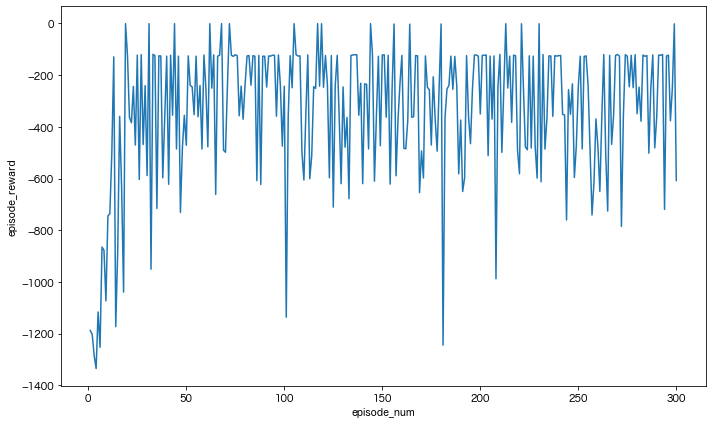

: 

In [146]:
plot_data = pd.DataFrame({
    'episode_num': np.arange(1, len(episode_reward_list) + 1),
    'episode_reward': episode_reward_list
})

plt.figure(figsize=(10, 6), facecolor='white')
sns.lineplot(
    data=plot_data,
    x='episode_num',
    y='episode_reward'
)
plt.tight_layout()
plt.savefig(result_dir_path.joinpath(f'dqn_reward_trend_{gym_game_name}.png'), dpi=300)

## 学習したモデルを使ってゲームをプレイ

In [ ]:
env = gym.make(gym_game_name)
state = env.reset()
episode_reward = 0
done = False
while not done:
    
    action = select_action(
        policy_net=main_net, state=state, action_list=action_list,
        epsilon=epsilon, is_train=False
    )
    state, reward, done, _ = env.step([action])

    env.render()
    episode_reward += reward

print('Game End Reward: {:.0f}'.format(episode_reward))
env.close()

Game End Reward: -359
